# 5. Textbook Enhancements 

In [1]:
import os
os.environ["XLA_FLAGS"]="--xla_gpu_cuda_data_dir=/usr/local/cuda-11.1"

In [2]:
import pandas as pd
import numpy as np

from IPython.display import Markdown
from tqdm.notebook import tqdm

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_fscore_support
from sklearn.metrics import f1_score, precision_score, recall_score

import matplotlib.pyplot as plt
import seaborn as sns

from keras import models
from keras import layers
from keras import optimizers
from keras import callbacks
from keras import backend as K

2023-01-05 16:53:47.339994: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-05 16:53:48.719913: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-01-05 16:53:48.720026: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-01-05 16:53:48.720034: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

## 5.1. Data Collection

In [3]:
# load the source data
df_source = pd.read_csv('data/raw/DataCoSupplyChainDataset.csv', encoding='unicode_escape')
df_source.drop_duplicates(inplace=True)

print(df_source.shape)
with pd.option_context('display.max_columns', None):
    display(df_source.head())

(180519, 53)


,Type,Days for shipping (real),Days for shipment (scheduled),Benefit per order,Sales per customer,Delivery Status,Late_delivery_risk,Category Id,Category Name,Customer City,Customer Country,Customer Email,Customer Fname,Customer Id,Customer Lname,Customer Password,Customer Segment,Customer State,Customer Street,Customer Zipcode,Department Id,Department Name,Latitude,Longitude,Market,Order City,Order Country,Order Customer Id,order date (DateOrders),Order Id,Order Item Cardprod Id,Order Item Discount,Order Item Discount Rate,Order Item Id,Order Item Product Price,Order Item Profit Ratio,Order Item Quantity,Sales,Order Item Total,Order Profit Per Order,Order Region,Order State,Order Status,Order Zipcode,Product Card Id,Product Category Id,Product Description,Product Image,Product Name,Product Price,Product Status,shipping date (DateOrders),Shipping Mode
0,DEBIT,3,4,91.250000,314.640015,Advance shipping,0,73,Sporting Goods,Caguas,Puerto Rico,XXXXXXXXX,Cally,20755,Holloway,XXXXXXXXX,Consumer,PR,5365 Noble Nectar Island,725.0,2,Fitness,18.251453,-66.037056,Pacific Asia,Bekasi,Indonesia,20755,1/31/2018 22:56,77202,1360,13.110000,0.04,180517,327.75,0.29,1,327.75,314.640015,91.250000,Southeast Asia,Java Occidental,COMPLETE,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,2/3/2018 22:56,Standard Class
1,TRANSFER,5,4,-249.089996,311.359985,Late delivery,1,73,Sporting Goods,Caguas,Puerto Rico,XXXXXXXXX,Irene,19492,Luna,XXXXXXXXX,Consumer,PR,2679 Rustic Loop,725.0,2,Fitness,18.279451,-66.037064,Pacific Asia,Bikaner,India,19492,1/13/2018 12:27,75939,1360,16.389999,0.05,179254,327.75,-0.80,1,327.75,311.359985,-249.089996,South Asia,Rajastán,PENDING,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/18/2018 12:27,Standard Class
2,CASH,4,4,-247.779999,309.720001,Shipping on time,0,73,Sporting Goods,San Jose,EE. UU.,XXXXXXXXX,Gillian,19491,Maldonado,XXXXXXXXX,Consumer,CA,8510 Round Bear Gate,95125.0,2,Fitness,37.292233,-121.881279,Pacific Asia,Bikaner,India,19491,1/13/2018 12:06,75938,1360,18.030001,0.06,179253,327.75,-0.80,1,327.75,309.720001,-247.779999,South Asia,Rajastán,CLOSED,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/17/2018 12:06,Standard Class
3,DEBIT,3,4,22.860001,304.809998,Advance shipping,0,73,Sporting Goods,Los Angeles,EE. UU.,XXXXXXXXX,Tana,19490,Tate,XXXXXXXXX,Home Office,CA,3200 Amber Bend,90027.0,2,Fitness,34.125946,-118.291016,Pacific Asia,Townsville,Australia,19490,1/13/2018 11:45,75937,1360,22.940001,0.07,179252,327.75,0.08,1,327.75,304.809998,22.860001,Oceania,Queensland,COMPLETE,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/16/2018 11:45,Standard Class
4,PAYMENT,2,4,134.210007,298.250000,Advance shipping,0,73,Sporting Goods,Caguas,Puerto Rico,XXXXXXXXX,Orli,19489,Hendricks,XXXXXXXXX,Corporate,PR,8671 Iron Anchor Corners,725.0,2,Fitness,18.253769,-66.037048,Pacific Asia,Townsville,Australia,19489,1/13/2018 11:24,75936,1360,29.500000,0.09,179251,327.75,0.45,1,327.75,298.250000,134.210007,Oceania,Queensland,PENDING_PAYMENT,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/15/2018 11:24,Standard Class


## 5.2 Data Preparation & Cleaning

### 5.2.1 Add the Target Variable

In [4]:
def add_is_fraud(df_data: pd.DataFrame) -> pd.DataFrame:
    """
    Add a new column to the dataframe that indicates
    0: No Fraud and 1: Fraud

    Parameters
    ----------
    df_data : pd.DataFrame
        The source dataframe
    """
    df_data['is_fraud'] = df_data['Order Status'].apply(lambda x: 1 if x == 'SUSPECTED_FRAUD' else 0)
    return df_data

df_data = df_source.reset_index(drop=True)
add_is_fraud(df_data)
df_data['is_fraud'].value_counts()

0    176457
1      4062
Name: is_fraud, dtype: int64

### 5.3.2 Hour-Month

This variable is calculated based on the variable "order-date".

In [5]:
def add_hour_month(df_data: pd.DataFrame) -> pd.DataFrame:
    """from sklearn.model_selection import train_test_split
    Parameters
    ----------
    df_data : pd.DataFrame
        The source dataframe
    """
    df_data['order_date'] = pd.to_datetime(df_data['order date (DateOrders)'])
    df_data['hour_month'] = (df_data['order_date'].dt.day * 24.0) + df_data['order_date'].dt.hour
    return df_data

add_hour_month(df_data)
df_data['hour_month'].describe()

count    180519.000000
mean        389.227993
std         211.850418
min          24.000000
25%         206.000000
50%         390.000000
75%         572.000000
max         767.000000
Name: hour_month, dtype: float64

### 5.2.3 Data Selection

Select the subset of columns to use for training the model.

In [6]:
df_data = df_data \
    .filter([
        'hour_month',
        'is_fraud',
        'Type',
        'Sales per customer',
        'Customer State',
        'Order State',
        'order_date',
    ]) \
    .rename(columns={
        'Type': 'payment_type',
        'Sales per customer': 'sales_per_customer',
        'Customer State': 'customer_state',
        'Order State': 'order_state',
    })

print(df_data.shape)
with pd.option_context('display.max_columns', None):
    display(df_data.head())    

(180519, 7)


,hour_month,is_fraud,payment_type,sales_per_customer,customer_state,order_state,order_date
0,766.0,0,DEBIT,314.640015,PR,Java Occidental,2018-01-31 22:56:00
1,324.0,0,TRANSFER,311.359985,PR,Rajastán,2018-01-13 12:27:00
2,324.0,0,CASH,309.720001,CA,Rajastán,2018-01-13 12:06:00
3,323.0,0,DEBIT,304.809998,CA,Queensland,2018-01-13 11:45:00
4,323.0,0,PAYMENT,298.250000,PR,Queensland,2018-01-13 11:24:00


### 5.2.4 Set Categorical Columns

In [7]:
cat_columns = {
        'payment_type',
        'customer_state',
        'order_state'
}

for col in cat_columns:
    df_data[col] = df_data[col].astype('category')

df_data.dtypes

hour_month                   float64
is_fraud                       int64
payment_type                category
sales_per_customer           float64
customer_state              category
order_state                 category
order_date            datetime64[ns]
dtype: object

## 5.3 Feature Engineering

### 5.3.1 One Hot Encode Categorical Columns

In [8]:
def one_hot_encode(df_data: pd.DataFrame) -> pd.DataFrame:
    """
    Perform one-hot encoding on the categorical columns 
    in the dataframe.

    Parameters
    ----------
    df_data : pd.DataFrame
        The source dataframe

    Returns
    -------
    pd.DataFrame
        The dataframe with the columns one-hot encoded.
    """
    df_output = df_data.copy()

    # one-hot encode the categorical columns
    for column in df_output.select_dtypes(include='category').columns:
        df_output = pd.concat([df_output, pd.get_dummies(df_output[column], prefix=column)], axis=1)
        df_output.drop(columns=[column], inplace=True)
        
    return df_output
    
df_features = one_hot_encode(df_data) \
    .drop(columns=['order_date'])

print(df_features.shape)
with pd.option_context('display.max_columns', None):
    display(df_features.head())

(180519, 1142)


,hour_month,is_fraud,sales_per_customer,payment_type_CASH,payment_type_DEBIT,payment_type_PAYMENT,payment_type_TRANSFER,customer_state_91732,customer_state_95758,customer_state_AL,customer_state_AR,customer_state_AZ,customer_state_CA,customer_state_CO,customer_state_CT,customer_state_DC,customer_state_DE,customer_state_FL,customer_state_GA,customer_state_HI,customer_state_IA,customer_state_ID,customer_state_IL,customer_state_IN,customer_state_KS,customer_state_KY,customer_state_LA,customer_state_MA,customer_state_MD,customer_state_MI,customer_state_MN,customer_state_MO,customer_state_MT,customer_state_NC,customer_state_ND,customer_state_NJ,customer_state_NM,customer_state_NV,customer_state_NY,customer_state_OH,customer_state_OK,customer_state_OR,customer_state_PA,customer_state_PR,customer_state_RI,customer_state_SC,customer_state_TN,customer_state_TX,customer_state_UT,customer_state_VA,customer_state_WA,customer_state_WI,customer_state_WV,order_state_Abia,order_state_Abruzos,order_state_Aceh,order_state_Acre,order_state_Adamaoua,order_state_Adamawa,order_state_Adana,order_state_Adiyaman,order_state_Afyonkarahisar,order_state_Aichi,order_state_Ajmán,order_state_Akmola,order_state_Aksaray,order_state_Akwa Ibom,order_state_Al Asimah,order_state_Al Bahr al Ahmar,order_state_Al Buhayrah,order_state_Al Hudayda,order_state_Al Jawf,order_state_Al Marqab,order_state_Alabama,order_state_Alagoas,order_state_Alberta,order_state_Alejandría,order_state_Alger,order_state_Alibori,order_state_Almaty,order_state_Alsacia-Champaña-Ardenas-Lorena,order_state_Alta Austria,order_state_Amapá,order_state_Amasya,order_state_Amazonas,order_state_Amberes,order_state_Amur,order_state_Amán,order_state_Analamanga,order_state_Anambra,order_state_Ancash,order_state_Andalucía,order_state_Andhra Pradesh,order_state_Andiján,order_state_Anhui,order_state_Ankara,order_state_Annaba,order_state_Anseba,order_state_Antalya,order_state_Antioquía,order_state_Antofagasta,order_state_Anzoátegui,order_state_Aomori,order_state_Apulia,order_state_Aquitania-Lemosín-Poitou-Charentes,order_state_Ar Raqa,order_state_Arad,order_state_Aragua,order_state_Arauca,order_state_Arbil,order_state_Ardahan,order_state_Ardebil,order_state_Arequipa,order_state_Arges,order_state_Arica y Parinacota,order_state_Arizona,order_state_Arjánguelsk,order_state_Arkansas,order_state_Artemisa,order_state_Artibonito,order_state_Arusha,order_state_Ash Sharqiyah,order_state_Ashanti,order_state_Asir,order_state_Asiut,order_state_Asjabad,order_state_Assam,order_state_Astaná,order_state_Astracán,order_state_Asturias,order_state_Asunción,order_state_Aswan,order_state_Atacama,order_state_Atakora,order_state_Atlántico,order_state_Atlántida,order_state_Atsimo-Andrefana,order_state_Atsinanana,order_state_Attica,order_state_Auckland,order_state_Australia Occidental,order_state_Australia del Sur,order_state_Auvernia,order_state_Auvernia-Ródano-Alpes,order_state_Aveiro,order_state_Ayacucho,order_state_Aydin,order_state_Azuay,order_state_Babilonia,order_state_Bacau,order_state_Baden-Wurtemberg,order_state_Bagdad,order_state_Bahía,order_state_Baja California,order_state_Baja California Sur,order_state_Baja Sajonia,order_state_Bajo Congo,order_state_Baki,order_state_Bali,order_state_Balikesir,order_state_Balti,order_state_Baluchistán,order_state_Bamako,order_state_Bandundu,order_state_Bangkok,order_state_Bangui,order_state_Bani Suwayf,order_state_Banská Bystrica,order_state_Barahona,order_state_Bashkortostán,order_state_Basilea-Ciudad,order_state_Basilicata,order_state_Basora,order_state_Batman,order_state_Batna,order_state_Bauchi,order_state_Bavaria,order_state_Bay of Plenty,order_state_Beirut,order_state_Benadir,order_state_Bengala Occidental,order_state_Bengasi,order_state_Bengkulu,order_state_Benguela,order_state_Benue,order_state_Berlín,order_state_Berna,order_state_Bihar,order_state_Bihor,order_state_Bingöl,order_state_Bishkek,order_state_Bistrita-Nasaud,order_state_Bisáu,order_state_Bitola,order_state_Bié,order_

### 5.3.2 Normalize the Data

In [9]:
def scale_features(df_data: pd.DataFrame) -> pd.DataFrame:
    """
    Scale the features in the dataframe.

    Parameters
    ----------
    df_data : pd.DataFrame
        The source dataframe

    Returns
    -------
    pd.DataFrame
        The dataframe with the columns scaled.
    """
    df_output = df_data.copy()
    float_columns = df_output.select_dtypes(include='float64').columns

    # scale the features
    scaler = StandardScaler()
    df_output[float_columns] = scaler.fit_transform(df_output[float_columns])

    return df_output

df_features = scale_features(df_features)

print(df_features.shape)
with pd.option_context('display.max_columns', None):
    display(df_features.head())

(180519, 1142)


,hour_month,is_fraud,sales_per_customer,payment_type_CASH,payment_type_DEBIT,payment_type_PAYMENT,payment_type_TRANSFER,customer_state_91732,customer_state_95758,customer_state_AL,customer_state_AR,customer_state_AZ,customer_state_CA,customer_state_CO,customer_state_CT,customer_state_DC,customer_state_DE,customer_state_FL,customer_state_GA,customer_state_HI,customer_state_IA,customer_state_ID,customer_state_IL,customer_state_IN,customer_state_KS,customer_state_KY,customer_state_LA,customer_state_MA,customer_state_MD,customer_state_MI,customer_state_MN,customer_state_MO,customer_state_MT,customer_state_NC,customer_state_ND,customer_state_NJ,customer_state_NM,customer_state_NV,customer_state_NY,customer_state_OH,customer_state_OK,customer_state_OR,customer_state_PA,customer_state_PR,customer_state_RI,customer_state_SC,customer_state_TN,customer_state_TX,customer_state_UT,customer_state_VA,customer_state_WA,customer_state_WI,customer_state_WV,order_state_Abia,order_state_Abruzos,order_state_Aceh,order_state_Acre,order_state_Adamaoua,order_state_Adamawa,order_state_Adana,order_state_Adiyaman,order_state_Afyonkarahisar,order_state_Aichi,order_state_Ajmán,order_state_Akmola,order_state_Aksaray,order_state_Akwa Ibom,order_state_Al Asimah,order_state_Al Bahr al Ahmar,order_state_Al Buhayrah,order_state_Al Hudayda,order_state_Al Jawf,order_state_Al Marqab,order_state_Alabama,order_state_Alagoas,order_state_Alberta,order_state_Alejandría,order_state_Alger,order_state_Alibori,order_state_Almaty,order_state_Alsacia-Champaña-Ardenas-Lorena,order_state_Alta Austria,order_state_Amapá,order_state_Amasya,order_state_Amazonas,order_state_Amberes,order_state_Amur,order_state_Amán,order_state_Analamanga,order_state_Anambra,order_state_Ancash,order_state_Andalucía,order_state_Andhra Pradesh,order_state_Andiján,order_state_Anhui,order_state_Ankara,order_state_Annaba,order_state_Anseba,order_state_Antalya,order_state_Antioquía,order_state_Antofagasta,order_state_Anzoátegui,order_state_Aomori,order_state_Apulia,order_state_Aquitania-Lemosín-Poitou-Charentes,order_state_Ar Raqa,order_state_Arad,order_state_Aragua,order_state_Arauca,order_state_Arbil,order_state_Ardahan,order_state_Ardebil,order_state_Arequipa,order_state_Arges,order_state_Arica y Parinacota,order_state_Arizona,order_state_Arjánguelsk,order_state_Arkansas,order_state_Artemisa,order_state_Artibonito,order_state_Arusha,order_state_Ash Sharqiyah,order_state_Ashanti,order_state_Asir,order_state_Asiut,order_state_Asjabad,order_state_Assam,order_state_Astaná,order_state_Astracán,order_state_Asturias,order_state_Asunción,order_state_Aswan,order_state_Atacama,order_state_Atakora,order_state_Atlántico,order_state_Atlántida,order_state_Atsimo-Andrefana,order_state_Atsinanana,order_state_Attica,order_state_Auckland,order_state_Australia Occidental,order_state_Australia del Sur,order_state_Auvernia,order_state_Auvernia-Ródano-Alpes,order_state_Aveiro,order_state_Ayacucho,order_state_Aydin,order_state_Azuay,order_state_Babilonia,order_state_Bacau,order_state_Baden-Wurtemberg,order_state_Bagdad,order_state_Bahía,order_state_Baja California,order_state_Baja California Sur,order_state_Baja Sajonia,order_state_Bajo Congo,order_state_Baki,order_state_Bali,order_state_Balikesir,order_state_Balti,order_state_Baluchistán,order_state_Bamako,order_state_Bandundu,order_state_Bangkok,order_state_Bangui,order_state_Bani Suwayf,order_state_Banská Bystrica,order_state_Barahona,order_state_Bashkortostán,order_state_Basilea-Ciudad,order_state_Basilicata,order_state_Basora,order_state_Batman,order_state_Batna,order_state_Bauchi,order_state_Bavaria,order_state_Bay of Plenty,order_state_Beirut,order_state_Benadir,order_state_Bengala Occidental,order_state_Bengasi,order_state_Bengkulu,order_state_Benguela,order_state_Benue,order_state_Berlín,order_state_Berna,order_state_Bihar,order_state_Bihor,order_state_Bingöl,order_state_Bishkek,order_state_Bistrita-Nasaud,order_state_Bisáu,order_state_Bitola,order_state_Bié,order_

## 5.4 Model Training

In [10]:
random_state = 105

### 5.4.1 Data Selection

In [11]:
# split the data into train and test, and validation sets
df_train, df_test = train_test_split(df_features, test_size=0.2, random_state=random_state)
df_train, df_val = train_test_split(df_train, test_size=0.3, random_state=random_state)

Markdown(f'''
| Dataset | Rows | Columns | Not Fraud | Fraud |
| ------- | ---- | ------- | --------- | ----- |
| Train | {df_train.shape[0]} | {df_train.shape[1]} | {df_train[df_train['is_fraud'] == 0].shape[0]} | {df_train[df_train['is_fraud'] == 1].shape[0]} |
| Validation | {df_val.shape[0]} | {df_val.shape[1]} | {df_val[df_val['is_fraud'] == 0].shape[0]} | {df_val[df_val['is_fraud'] == 1].shape[0]} |
| Test | {df_test.shape[0]} | {df_test.shape[1]} | {df_test[df_test['is_fraud'] == 0].shape[0]} | {df_test[df_test['is_fraud'] == 1].shape[0]} |
''')


| Dataset | Rows | Columns | Not Fraud | Fraud |
| ------- | ---- | ------- | --------- | ----- |
| Train | 101090 | 1142 | 98851 | 2239 |
| Validation | 43325 | 1142 | 42374 | 951 |
| Test | 36104 | 1142 | 35232 | 872 |


In [12]:
# get the features and labels
x_train = df_train.drop(columns=['is_fraud'])
y_train = df_train['is_fraud']

x_val = df_val.drop(columns=['is_fraud'])
y_val = df_val['is_fraud']

x_test = df_test.drop(columns=['is_fraud'])
y_test = df_test['is_fraud']

In [13]:
# try to reclaim some memory
del df_source
del df_data
del df_features

del df_train
del df_val
del df_test


### 5.4.2 Model Definition

In [14]:
def get_model() -> models.Sequential:
    """
    Get the deep learning model to use for training.
    """
    model = models.Sequential()
    model.add(layers.Dense(512, activation='relu', input_shape=(x_train.shape[1],)))
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))

    return model

In [15]:
model = get_model()

2023-01-05 16:54:10.944944: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-05 16:54:11.077045: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-05 16:54:11.077239: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-05 16:54:11.077663: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorF

### 5.4.3 Model Compilation

In [16]:
model.compile(
    optimizer=optimizers.RMSprop(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy'])

### 5.4.4 Model Training

In [17]:
history = model.fit(
    x_train,
    y_train,
    epochs=30,
    batch_size=512,
    validation_data=(x_val, y_val))

2023-01-05 16:54:12.801833: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 922749520 exceeds 10% of free system memory.
2023-01-05 16:54:13.270859: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 922749520 exceeds 10% of free system memory.


Epoch 1/30
 41/198 [=====>........................] - ETA: 0s - loss: 0.3941 - accuracy: 0.9671

2023-01-05 16:54:15.390574: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


198/198 [==============================] - 3s 8ms/step - loss: 0.1666 - accuracy: 0.9758 - val_loss: 0.0823 - val_accuracy: 0.9780
Epoch 2/30
198/198 [==============================] - 1s 5ms/step - loss: 0.0783 - accuracy: 0.9779 - val_loss: 0.0766 - val_accuracy: 0.9780
Epoch 3/30
198/198 [==============================] - 1s 5ms/step - loss: 0.0748 - accuracy: 0.9779 - val_loss: 0.0756 - val_accuracy: 0.9780
Epoch 4/30
198/198 [==============================] - 1s 5ms/step - loss: 0.0731 - accuracy: 0.9779 - val_loss: 0.0752 - val_accuracy: 0.9780
Epoch 5/30
198/198 [==============================] - 1s 5ms/step - loss: 0.0718 - accuracy: 0.9779 - val_loss: 0.0753 - val_accuracy: 0.9780
Epoch 6/30
198/198 [==============================] - 1s 5ms/step - loss: 0.0707 - accuracy: 0.9779 - val_loss: 0.0752 - val_accuracy: 0.9780
Epoch 7/30
198/198 [==============================] - 1s 5ms/step - loss: 0.0697 - accuracy: 0.9779 - val_loss: 0.0750 - val_accuracy: 0.9781
Epoch 8/30
198/19

In [18]:
history_dict = history.history
print(history_dict.keys())


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


In [19]:
def plot_loss(history: callbacks.History) -> None:
    """
    Plot the loss and validation loss.

    Parameters
    ----------
    history : keras.callbacks.History
        The history of the model training.
    """
    epochs = range(1, len(history.history['accuracy']) + 1)

    # summarize history for loss
    plt.plot(epochs, history.history['loss'])
    
    if ('val_loss' in history.history):
        plt.plot(epochs, history.history['val_loss'])
        plt.legend(['Training loss', 'Validation loss'], loc='upper left')
        plt.title('Training and validation loss')
    else:
        plt.title('Training loss')

    plt.xlabel('Epochs')
    plt.ylabel('Loss')

    plt.show()        

In [20]:
def plot_accuracy(history: callbacks.History) -> None:
    """
    Plot the accuracy and validation accuracy.

    Parameters
    ----------
    history : keras.callbacks.History
        The history of the model training.
    """
    epochs = range(1, len(history.history['accuracy']) + 1)

    # summarize history for accuracy
    plt.plot(epochs, history.history['accuracy'])

    if ('val_accuracy' in history.history):
        plt.plot(epochs, history.history['val_accuracy'])
        plt.legend(['Training acc', 'Validation acc'], loc='upper left')
        plt.title('Training and validation accuracy')
    else:
        plt.title('Training accuracy')

    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')

    plt.show()

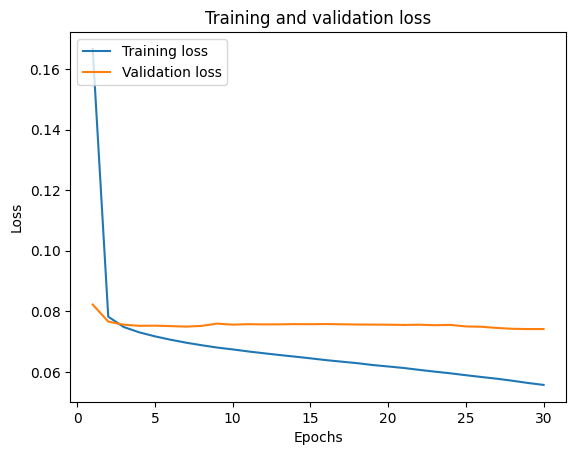

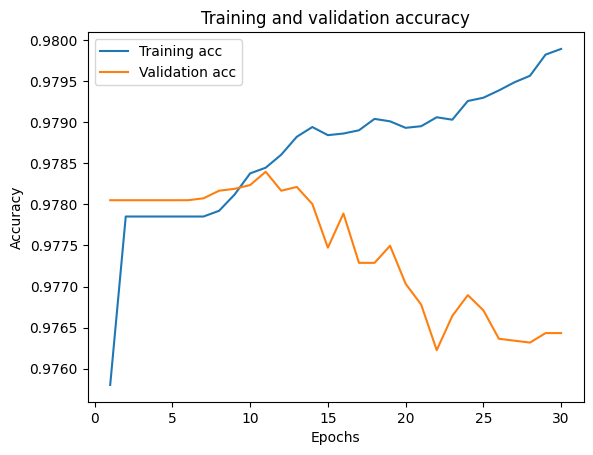

In [21]:
plot_loss(history)
plot_accuracy(history)

In [22]:
def show_loss_accuracy(model: models.Sequential) -> None:
    """
    Show the loss and accuracy for the model.

    Parameters
    ----------
    model : keras.models.Sequential
        The model to evaluate.
    """
    print('-- Training --')
    train_loss, train_acc = model.evaluate(x_train, y_train)

    print('-- Validation --')
    val_loss, val_acc = model.evaluate(x_val, y_val)

    print('-- Test --')
    test_loss, test_acc = model.evaluate(x_test, y_test)

In [23]:
# show the accuracy and loss on the data sets
show_loss_accuracy(model)

-- Training --


2023-01-05 16:54:48.117867: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 922749520 exceeds 10% of free system memory.
2023-01-05 16:54:48.497601: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 922749520 exceeds 10% of free system memory.


3160/3160 [==============================] - 4s 1ms/step - loss: 0.0543 - accuracy: 0.9805
-- Validation --
1354/1354 [==============================] - 2s 1ms/step - loss: 0.0742 - accuracy: 0.9764
-- Test --
1129/1129 [==============================] - 2s 1ms/step - loss: 0.0801 - accuracy: 0.9745


## 5.5 Model Evaluation

In [24]:
def predict(x: pd.DataFrame, y: pd.Series, model: models.Sequential, threshold: float = 0.5) -> pd.DataFrame:
    """
    Predict the labels for the features to use for model evaluation.

    Parameters
    ----------
    x : pd.DataFrame
        The features
    y : pd.Series
        The labels
    model : models.Sequential
        The model
    threshold : float, optional
        The threshold to use for the predictions, by default 0.5

    Returns
    -------
    pd.DataFrame
        The confusion matrix
    """
    y_score = model.predict(x).ravel()

    return pd.DataFrame({
        'y_true': y,
        'y_score': y_score,
        'y_pred': y_score > threshold,
    })
    

#return pd.DataFrame(confusion_matrix(y, y_pred), columns=['Predicted Not Fraud', 'Predicted Fraud'], index=['Actual Not Fraud', 'Actual Fraud'])


In [25]:
threshold = 0.2

train_predict = predict(x_train, y_train, model, threshold)
val_predict = predict(x_val, y_val, model, threshold)
test_predict = predict(x_test, y_test, model, threshold)

2023-01-05 16:54:57.704734: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 922749520 exceeds 10% of free system memory.


1129/1129 [==============================] - 1s 814us/step


### 4.5.1. Confusion Matrix

In [26]:
def plot_confusion_matrix(df_predict: pd.DataFrame, title: str, axes: plt.Axes = None):
    """
    Plot the confusion matrix for the predictions.

    Parameters
    ----------
    df_predict : pd.DataFrame
        The predictions
    title : str
        The title for the plot
    axes : plt.Axes, optional
        The axes to plot on, by default None
    """
    cm = confusion_matrix(df_predict['y_true'], df_predict['y_pred'])
    sns.heatmap(
        cm,
        annot=True,
        fmt='d',
        cmap='Blues',
        cbar=False,
        xticklabels=['Not Fraud', 'Fraud'],
        yticklabels=['Not Fraud', 'Fraud'],
        linewidths=0.5,
        linecolor='black',
        square=True,
        ax=axes,
    ).set_title(f'{title} Confusion Matrix')

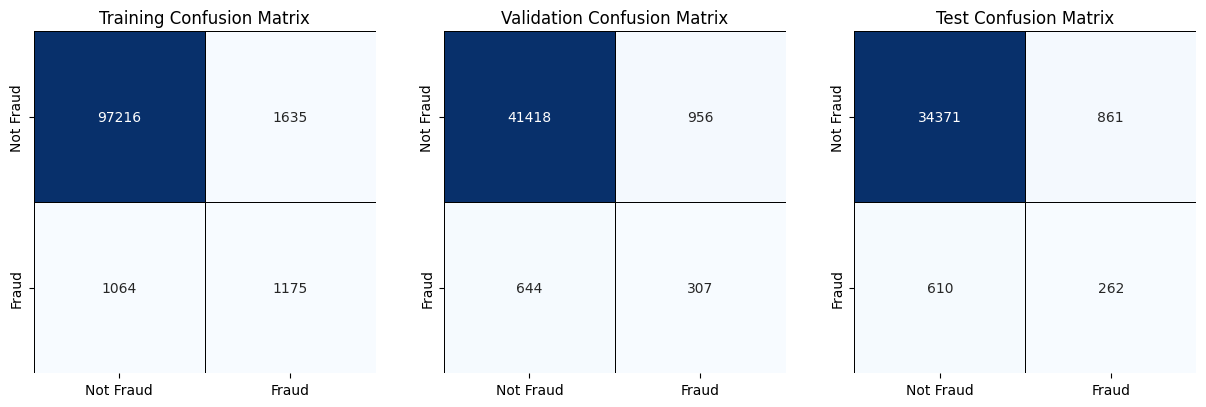

In [27]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=False)

plot_confusion_matrix(train_predict, 'Training', axes=axes[0])
plot_confusion_matrix(val_predict, 'Validation', axes=axes[1])
plot_confusion_matrix(test_predict, 'Test', axes=axes[2])

### 4.5.2 Classification Result

In [28]:
def show_classification_report(df_predict: pd.DataFrame, title: str):
    """
    Show the classification report for the predictions.

    Parameters
    ----------
    df_predict : pd.DataFrame
        The predictions
    title : str
        The title for the report
    """
    print(f'--- {title} Classification Report ---')
    print(classification_report(df_predict['y_true'], df_predict['y_pred']))

In [29]:
show_classification_report(train_predict, 'Training')
show_classification_report(val_predict, 'Validation')
show_classification_report(test_predict, 'Test')

--- Training Classification Report ---
              precision    recall  f1-score   support

           0       0.99      0.98      0.99     98851
           1       0.42      0.52      0.47      2239

    accuracy                           0.97    101090
   macro avg       0.70      0.75      0.73    101090
weighted avg       0.98      0.97      0.97    101090

--- Validation Classification Report ---
              precision    recall  f1-score   support

           0       0.98      0.98      0.98     42374
           1       0.24      0.32      0.28       951

    accuracy                           0.96     43325
   macro avg       0.61      0.65      0.63     43325
weighted avg       0.97      0.96      0.97     43325

--- Test Classification Report ---
              precision    recall  f1-score   support

           0       0.98      0.98      0.98     35232
           1       0.23      0.30      0.26       872

    accuracy                           0.96     36104
   macro avg 

## 5.6 Parameter Tuning

### 5.6.1 Create Model

In [30]:
# create a new model to tune
tuned_model = get_model()

# compile the model
tuned_model.compile(
    optimizer=optimizers.RMSprop(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy'])

### 5.6.2 Model Training

In [31]:
tuned_history = tuned_model.fit(
    pd.concat([x_train, x_val]),
    pd.concat([y_train, y_val]),
    epochs=15,
    batch_size=512)

Epoch 1/15
283/283 [==============================] - 1s 4ms/step - loss: 0.1395 - accuracy: 0.9765
Epoch 2/15
283/283 [==============================] - 1s 4ms/step - loss: 0.0763 - accuracy: 0.9779
Epoch 3/15
283/283 [==============================] - 1s 4ms/step - loss: 0.0737 - accuracy: 0.9779
Epoch 4/15
283/283 [==============================] - 1s 4ms/step - loss: 0.0722 - accuracy: 0.9779
Epoch 5/15
283/283 [==============================] - 1s 4ms/step - loss: 0.0709 - accuracy: 0.9779
Epoch 6/15
283/283 [==============================] - 1s 4ms/step - loss: 0.0701 - accuracy: 0.9779
Epoch 7/15
283/283 [==============================] - 1s 4ms/step - loss: 0.0694 - accuracy: 0.9781
Epoch 8/15
283/283 [==============================] - 1s 4ms/step - loss: 0.0687 - accuracy: 0.9782
Epoch 9/15
283/283 [==============================] - 1s 4ms/step - loss: 0.0681 - accuracy: 0.9784
Epoch 10/15
283/283 [==============================] - 1s 4ms/step - loss: 0.0675 - accuracy: 0.9785

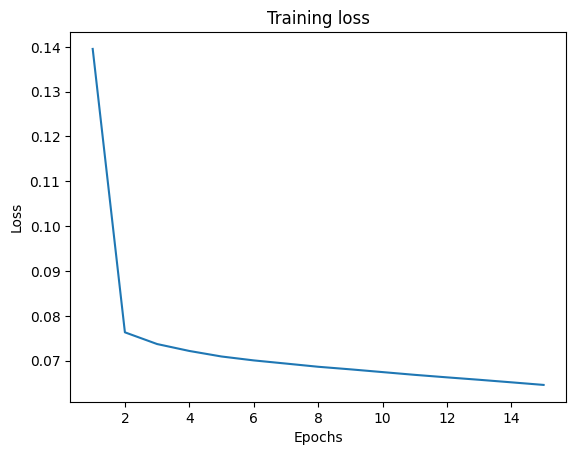

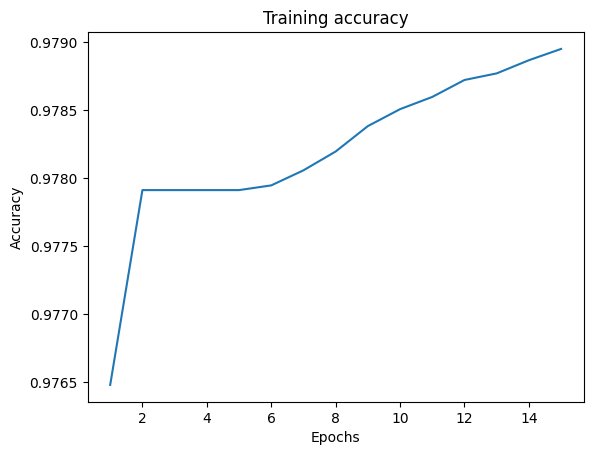

In [32]:
plot_loss(tuned_history)
plot_accuracy(tuned_history)

In [33]:
# show the accuracy and loss on the data sets
show_loss_accuracy(tuned_model)

-- Training --
3160/3160 [==============================] - 4s 1ms/step - loss: 0.0638 - accuracy: 0.9791
-- Validation --
1354/1354 [==============================] - 2s 1ms/step - loss: 0.0632 - accuracy: 0.9793
-- Test --
  37/1129 [..............................] - ETA: 1s - loss: 0.0771 - accuracy: 0.9764 

### 5.6.3 Model Evaluation

In [ ]:
threshold = 0.2

train_predict = predict(x_train, y_train, tuned_model, threshold)
val_predict = predict(x_val, y_val, tuned_model, threshold)
test_predict = predict(x_test, y_test, tuned_model, threshold)

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=False)

plot_confusion_matrix(train_predict, 'Training', axes=axes[0])
plot_confusion_matrix(val_predict, 'Validation', axes=axes[1])
plot_confusion_matrix(test_predict, 'Test', axes=axes[2])

In [ ]:
show_classification_report(train_predict, 'Training')
show_classification_report(val_predict, 'Validation')
show_classification_report(test_predict, 'Test')

## 5.7 Maximize Minority Class F1

In [ ]:
def maximize_f1(
        x_train: pd.DataFrame,
        y_train: pd.DataFrame,
        x_val: pd.DataFrame,
        y_val: pd.DataFrame,
        x_test: pd.DataFrame,
        y_test: pd.DataFrame,
        learning_rates: list,
        epochs: int,
        thresholds: list) -> pd.DataFrame:
    """
    Find the best learning rate and number of epocs to train for to 
    maximize the F1 score of the minirity class on the test set.
    
    Parameters
    ----------
    x_train : pd.DataFrame
        The training features
    y_train : pd.DataFrame
        The training labels
    x_val : pd.DataFrame
        The validation features
    y_val : pd.DataFrame
        The validation labels
    x_test : pd.DataFrame
        The test features
    y_test : pd.DataFrame
        The test labels
    learning_rates : list
        The learning rates to try
    epochs : int
        The max number of epochs to train for
    thresholds : list
    """
    # create a dataframe to store the results
    df_results = pd.DataFrame()

    for learning_rate in tqdm(learning_rates):
        # clear the session
        K.clear_session()

        # create the new model
        model = get_model()

        # compile the model
        model.compile(
            optimizer=optimizers.RMSprop(learning_rate=learning_rate),
            loss='binary_crossentropy',
            metrics=['accuracy'])

        # train the model one epoch at a time
        for epoch in tqdm(range(epochs)):
            model.fit(
                x_train,
                y_train,
                epochs=1,
                batch_size=512,
                verbose=0)

            for threshold in tqdm(thresholds):
                # get the predictions
                # train_predict = predict(x_train, y_train, tuned_model, threshold)
                # val_predict = predict(x_val, y_val, tuned_model, threshold)
                test_predict = predict(x_test, y_test, model, threshold)

                # calculate the metrics
                metrics = precision_recall_fscore_support(
                    test_predict['y_true'], 
                    test_predict['y_pred'],
                    zero_division=1)
                
                # format the metrics
                df_metrics = pd.DataFrame(metrics) \
                    .set_axis(['precision', 'recall', 'f_score', 'true_sum'], axis=0) \
                    .T \
                    .assign(learning_rate=learning_rate, epoch=epoch+1, threshold=threshold) \
                    .reset_index() \
                    .rename(columns={'index': 'label'})

                df_results = pd.concat([df_results, df_metrics])


    return df_results

# get the metic results
df_results = maximize_f1(
    x_train=x_train, 
    y_train=y_train, 
    x_val=x_val, 
    y_val=y_val, 
    x_test=x_test, 
    y_test=y_test, 
    learning_rates=[0.00001, 0.0001, 0.001, 0.01], 
    epochs=2, 
    thresholds=np.arange(0.1, 1, 0.1))

# show the results
df_results \
    .query('label == 1') \
    .sort_values('f_score', ascending=False) \
    .head(10)

In [ ]:
# df_results \
#     .query('label == 1') \
#     .sort_values('f_score', ascending=False) \
#     .head(10)

In [ ]:
f1_score(test_predict['y_true'], test_predict['y_pred'], average=None)

In [ ]:
precision, recall, f_score, true_sum = precision_recall_fscore_support(val_predict['y_true'], val_predict['y_pred'])
a = precision_recall_fscore_support(val_predict['y_true'], val_predict['y_pred'])

pd.DataFrame(a) \
    .set_axis(['precision', 'recall', 'f_score', 'true_sum'], axis=0) \
    .T \
    .assign(learning_rate=1) \
    .reset_index() \
    .rename(columns={'index': 'label'})

#.rename(columns=['precision', 'recall', 'f_score', 'true_sum'])